In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import cifar10

Using TensorFlow backend.


In [0]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x


def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

def plot_loss(loss):
    plt.plot(loss, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()
    

def plot_multiple_loss(loss1, loss2, loss3, loss4):
    plt.plot(loss1, 'r-', label='GD')
    plt.plot(loss2, 'y-', label='AdaGrad')
    plt.plot(loss3, 'c-', label='Momentum=0.7')
    plt.plot(loss4, 'm-', label='Adam')
    plt.title('Loss vs Epoches')
    plt.ylabel('Loss')
    plt.xlabel('Training Epoches')
    plt.legend()
    plt.show()

    
def plot_multiple_error(err1, err2, err3, err4, top1=False):
    plt.plot(err1, 'r-', label='GD')
    plt.plot(err2, 'y-', label='AdaGrad')
    plt.plot(err3, 'c-', label='Momentum=0.7')
    plt.plot(err4, 'm-', label='Adam')
    if top1:
      plt.title('Top 1 Error vs Epoches')
    else:
      plt.title('Top 5 Error vs Epoches')
      
    plt.ylabel('Error')
    plt.xlabel('Training Epoches')
    plt.legend()
    plt.show()
    

def classification_cnn(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        # TensorFlow’s convolutional conv2d operation expects a 4-dimensional tensor
        #  with dimensions corresponding to batch, width, height and channel.
        inputs = tf.reshape(data, [-1, 32, 32, 3])

        # convolutional layer 1
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)
        # pooling layer
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        dropout1 = tf.layers.dropout(inputs=pool1, rate=0.2, training=training)

        # convolutional layer 2
        conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        dropout2 = tf.layers.dropout(inputs=pool2, rate=0.2, training=training)

        # convolutional layer 3
        conv3 = tf.layers.conv2d(inputs=dropout2, filters=64, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
        dropout3 = tf.layers.dropout(inputs=pool3, rate=0.2, training=training)

        conv_flat = tf.layers.flatten(dropout3)

        # dense layer
        h1 = tf.layers.dense(inputs=conv_flat, units=1000, activation=tf.nn.relu)
        dropout = tf.layers.dropout(inputs=h1, rate=0.4, training=training)

        # output layer
        outputs = tf.layers.dense(inputs=dropout, units=10, activation=None)
    return outputs

In [3]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()
n_data = data_train.shape[0]

norm_training_data = np.asarray([normalize(a) for a in data_train])
norm_test_data = np.asarray([normalize(a) for a in data_test])
one_hot_train_labels = np.asarray(one_hot_encode(label_train), np.uint8)
label_test = np.squeeze(label_test)

batch_size = 128
learning_rate = 0.001

170500096/170498071 [==============================] - 19s 0us/step


In [0]:
with tf.variable_scope('main', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(tf.float64, shape=(batch_size, 32, 32, 3), name='input_x')
    y = tf.placeholder(tf.uint8, shape=(batch_size, 10), name='output_y')

    outputs = classification_cnn(x, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=outputs))
    
    # Optimizers
    optimizer1 = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer2 = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
    optimizer3 = tf.train.MomentumOptimizer(learning_rate, momentum=0.7, use_nesterov=True).minimize(loss)
    optimizer4 = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    preds = classification_cnn(norm_test_data, training=False)
    predictions = tf.cast(tf.nn.softmax(preds), tf.float32)
    predictions_idx = tf.argmax(predictions, axis=1)
    accuracy, update_op = tf.metrics.accuracy(labels=label_test, predictions=predictions_idx)
    top_1 = tf.math.in_top_k(predictions, label_test, 1)
    top_5 = tf.math.in_top_k(predictions, label_test, 5)
    

epochs = 100
n_batches = 50
randomize = np.arange(n_data)
loss_list_1 = []
top_1_error_1 = []
top_5_error_1 = []


with tf.Session() as sess:
  print('Start')
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())

  for epoch in range(epochs):
      print("Epoch:", epoch + 1)
      np.random.shuffle(randomize)
      data = norm_training_data[randomize]
      labels = one_hot_train_labels[randomize]
        
      epoch_loss_list = []
      epoch_top_1_error = []
      epoch_top_5_error = []

      for n in range(n_batches):
          batch_x = data[n * batch_size:(n + 1) * batch_size]
          batch_y = labels[n * batch_size:(n + 1) * batch_size]

          _, loss_val, acc, op, top1, top5 = sess.run([optimizer1, loss, accuracy, update_op, top_1, top_5], feed_dict={x: batch_x, y: batch_y})

          epoch_loss_list.append(loss_val)
          error1 = (len(label_test) - np.sum(top1)) / len(label_test)
          error5 = (len(label_test) - np.sum(top5)) / len(label_test)
          epoch_top_1_error.append(error1)
          epoch_top_5_error.append(error5)

            
      loss_list_1.append(np.mean(epoch_loss_list))
      top_1_error_1.append(np.mean(epoch_top_1_error))
      top_5_error_1.append(np.mean(epoch_top_5_error))
      
      if len(loss_list_1) % 50 == 0 and len(loss_list_1) != 0:
        plot_loss(loss_list_1)

In [0]:
loss_list_2 = []
top_1_error_2 = []
top_5_error_2 = []


with tf.Session() as sess:
  print('Start')
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())

  for epoch in range(epochs):
      print("Epoch:", epoch + 1)
      np.random.shuffle(randomize)
      data = norm_training_data[randomize]
      labels = one_hot_train_labels[randomize]
        
      epoch_loss_list = []
      epoch_top_1_error = []
      epoch_top_5_error = []

      for n in range(n_batches):
          batch_x = data[n * batch_size:(n + 1) * batch_size]
          batch_y = labels[n * batch_size:(n + 1) * batch_size]

          _, loss_val, acc, op, top1, top5 = sess.run([optimizer2, loss, accuracy, update_op, top_1, top_5], feed_dict={x: batch_x, y: batch_y})

          epoch_loss_list.append(loss_val)
          error1 = (len(label_test) - np.sum(top1)) / len(label_test)
          error5 = (len(label_test) - np.sum(top5)) / len(label_test)
          epoch_top_1_error.append(error1)
          epoch_top_5_error.append(error5)

            
      loss_list_2.append(np.mean(epoch_loss_list))
      top_1_error_2.append(np.mean(epoch_top_1_error))
      top_5_error_2.append(np.mean(epoch_top_5_error))
      
      if len(loss_list_2) % 50 == 0 and len(loss_list_2) != 0:
        plot_loss(loss_list_2)

In [0]:
loss_list_3 = []
top_1_error_3 = []
top_5_error_3 = []


with tf.Session() as sess:
  print('Start')
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())

  for epoch in range(epochs):
      print("Epoch:", epoch + 1)
      np.random.shuffle(randomize)
      data = norm_training_data[randomize]
      labels = one_hot_train_labels[randomize]
        
      epoch_loss_list = []
      epoch_top_1_error = []
      epoch_top_5_error = []

      for n in range(n_batches):
          batch_x = data[n * batch_size:(n + 1) * batch_size]
          batch_y = labels[n * batch_size:(n + 1) * batch_size]

          _, loss_val, acc, op, top1, top5 = sess.run([optimizer3, loss, accuracy, update_op, top_1, top_5], feed_dict={x: batch_x, y: batch_y})

          epoch_loss_list.append(loss_val)
          error1 = (len(label_test) - np.sum(top1)) / len(label_test)
          error5 = (len(label_test) - np.sum(top5)) / len(label_test)
          epoch_top_1_error.append(error1)
          epoch_top_5_error.append(error5)

            
      loss_list_3.append(np.mean(epoch_loss_list))
      top_1_error_3.append(np.mean(epoch_top_1_error))
      top_5_error_3.append(np.mean(epoch_top_5_error))
      
      if len(loss_list_3) % 50 == 0 and len(loss_list_3) != 0:
        plot_loss(loss_list_3)

In [0]:
loss_list_4 = []
top_1_error_4 = []
top_5_error_4 = []


with tf.Session() as sess:
  print('Start')
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())

  for epoch in range(epochs):
      print("Epoch:", epoch + 1)
      np.random.shuffle(randomize)
      data = norm_training_data[randomize]
      labels = one_hot_train_labels[randomize]
        
      epoch_loss_list = []
      epoch_top_1_error = []
      epoch_top_5_error = []

      for n in range(n_batches):
          batch_x = data[n * batch_size:(n + 1) * batch_size]
          batch_y = labels[n * batch_size:(n + 1) * batch_size]

          _, loss_val, acc, op, top1, top5 = sess.run([optimizer4, loss, accuracy, update_op, top_1, top_5], feed_dict={x: batch_x, y: batch_y})

          epoch_loss_list.append(loss_val)
          error1 = (len(label_test) - np.sum(top1)) / len(label_test)
          error5 = (len(label_test) - np.sum(top5)) / len(label_test)
          epoch_top_1_error.append(error1)
          epoch_top_5_error.append(error5)

            
      loss_list_4.append(np.mean(epoch_loss_list))
      top_1_error_4.append(np.mean(epoch_top_1_error))
      top_5_error_4.append(np.mean(epoch_top_5_error))
      
      if len(loss_list_4) % 50 == 0 and len(loss_list_4) != 0:
        plot_loss(loss_list_4)

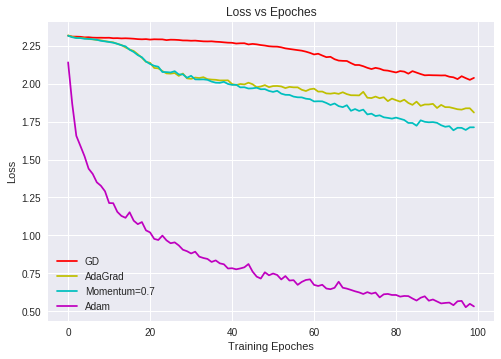

In [9]:
plot_multiple_loss(loss_list_1, loss_list_2, loss_list_3, loss_list_4)

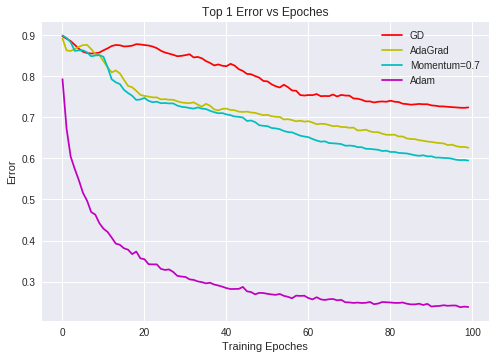

In [10]:
plot_multiple_error(top_1_error_1, top_1_error_2, top_1_error_3, top_1_error_4, top1=True)

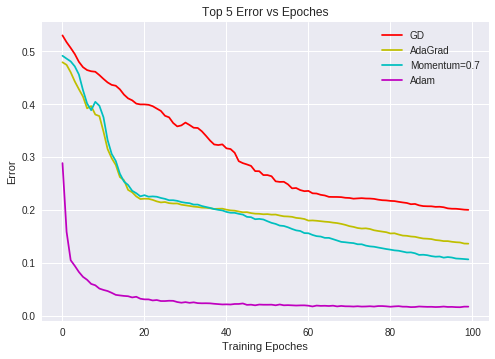

In [11]:
plot_multiple_error(top_5_error_1, top_5_error_2, top_5_error_3, top_5_error_4)